In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score

import statsmodels.api as sm
import statsmodels.formula.api as smf

import scipy.stats as stats
from sklearn.preprocessing import RobustScaler
import warnings
warnings.filterwarnings("ignore")



drop_cols = [
    "TWD","COG","TWA", "TimeUTC", "SecondsSince1970", "ISODateTimeUTC",
    "Lat", "LatBow", "LatCenter", "LatStern", "Lon", "LonBow", "LonCenter", "LonStern",
    "Leg", "Log", "LogAlongCourse", "MagneticVariation", "Rank", "TimeLocal",
    "DistanceToLeader", "interval_id", "boat_name", "interval_duration",
    "Heel", "Heel_Lwd", "Line_R", "Line_L", "BelowLineCalc", "VMC","XTE","VMG","gain_forward","gain_lateral", "gain_vmg","Total_lines", "LoadCell_1","LoadCell_2","LoadCell_3","LoadCell_4","LoadCell_5","LoadCell_6","M_tot_X","M_tot_Y","M_front_X","M_front_Y","M_back_X","M_back_Y","P_front_X","P_front_Y","P_back_X","P_back_Y"
]

def show_correlation_matrix(dataframe, taille_figure=(6, 4), cmap="coolwarm"):
    plt.figure(figsize=taille_figure)
    sns.heatmap(dataframe.corr(), cmap=cmap, center=0)
    plt.title("Correlation matrix")
    plt.show()

def show_target_correlation(df, variable="SOG", taille_figure=(6, 4)):
    corr_with_vmg = df.corr()[variable].sort_values(ascending=False)
    #print(f"Correlation with {variable} :")
    # print(corr_with_vmg)
    
    plt.figure(figsize=taille_figure)
    sns.heatmap(corr_with_vmg.to_frame(), annot=True, cmap="coolwarm")
    plt.title(f"Correlation with {variable}")
    plt.show()

def compute_anova(df, target="SOG"):
    # Make a copy of the DataFrame to avoid modifying the original
    df_copy = df.copy()
    cols = df_copy.columns.drop(target)
    df_no_missing = df_copy.dropna(subset=cols)
    if df_no_missing.empty:
        print("⚠️ Pas assez de données non-nulles pour faire une ANOVA.")
        return pd.DataFrame()  # retourne un DataFrame vide ou None
    formula_no_missing = f"{target} ~ " + " + ".join(
        list(df_no_missing.columns.drop(target)))
    model_no_missing = smf.ols(formula=formula_no_missing, data=df_no_missing).fit()
    anova_no_missing = sm.stats.anova_lm(model_no_missing, typ=2)
    return anova_no_missing.sort_values("F", ascending=False)

# With simple standard scaler
def linear_regression(df, target="SOG", degree=1, top_coefs=30):
    df_copy = df.copy()
    cols = df_copy.columns.drop(target)

    df_clean = df_copy.dropna(subset=cols)
    if df_clean[target].isna().any():
        df_clean = df_clean.dropna(subset=[target])

    X = df_clean[cols]
    y = df_clean[target]

    poly = PolynomialFeatures(degree=degree, include_bias=False)
    X_poly = poly.fit_transform(X)
    feature_names = poly.get_feature_names_out(X.columns)

    model = make_pipeline(
        StandardScaler(),
        LinearRegression()
    )

    model.fit(X_poly, y)
    y_pred = model.predict(X_poly)

    # Affichage de la performance
    print(f"R²: {r2_score(y, y_pred):.3f}")
    print(f"Used samples: {len(X)}")

    # Coefficients
    coefs = model.named_steps['linearregression'].coef_
    intercept = model.named_steps['linearregression'].intercept_

    coef_df = pd.DataFrame({
        'feature': feature_names,
        'coefficient': coefs
    }).sort_values('coefficient', key=abs, ascending=False)

    # Formule affichée
    print("\n Formula :")
    terms = [f"{coef:.3f} * {feat}" for feat, coef in zip(feature_names, coefs)]
    equation = " +\n  ".join(terms)
    print(f"{target} ≈ {intercept:.3f} +\n  {equation}")

    return coef_df.head(top_coefs)
"""
from sklearn.linear_model import RidgeCV
# Regularisaton with lasso
def linear_regression(df, target="SOG", top_coefs=30):
    df_copy = df.copy()
    cols = df_copy.columns.drop(target)

    # Drop rows with missing values
    df_clean = df_copy.dropna(subset=cols)
    if df_clean[target].isna().any():
        df_clean = df_clean.dropna(subset=[target])

    X = df_clean[cols]
    y = df_clean[target]

    # Ridge regression with standard scaling
    model = make_pipeline(
        StandardScaler(),
        RidgeCV(alphas=[0.1, 1.0, 10.0])
    )

    model.fit(X, y)
    y_pred = model.predict(X)

    # Performance
    print(f"R²: {r2_score(y, y_pred):.3f}")
    print(f"Used samples: {len(X)}")

    # Extract coefficients
    coefs = model.named_steps['ridgecv'].coef_
    intercept = model.named_steps['ridgecv'].intercept_

    coef_df = pd.DataFrame({
        'feature': X.columns,
        'coefficient': coefs
    }).sort_values('coefficient', key=abs, ascending=False)

    # Display formula
    print("\nFormula:")
    terms = [f"{coef:.3f} * {feat}" for feat, coef in zip(X.columns, coefs)]
    equation = " +\n  ".join(terms)
    print(f"{target} ≈ {intercept:.3f} +\n  {equation}")

    return coef_df.head(top_coefs)

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import r2_score

def linear_regression(df, target="SOG", top_coefs=30):
    df_copy = df.copy()

    # Drop missing values
    df_clean = df_copy.dropna(subset=[target] + [col for col in df_copy.columns if col != target])
    X = df_clean.drop(columns=[target])
    y = df_clean[target]

    # Manual robust scaling
    scaler = RobustScaler()
    X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

    # OLS Regression
    model = LinearRegression()
    model.fit(X_scaled, y)
    y_pred = model.predict(X_scaled)

    # Model performance
    print(f"R²: {r2_score(y, y_pred):.3f}")
    print(f"Used samples: {len(X_scaled)}")

    # Coefficient analysis
    coefs = model.coef_
    intercept = model.intercept_

    coef_df = pd.DataFrame({
        "feature": X.columns,
        "coefficient": coefs
    }).sort_values("coefficient", key=abs, ascending=False)

    # Print readable formula
    print("\nFormula:")
    terms = [f"{coef:.3f} * {feat}" for feat, coef in zip(X.columns, coefs)]
    equation = " +\n  ".join(terms)
    print(f"{target} ≈ {intercept:.3f} +\n  {equation}")

    return coef_df.head(top_coefs)
"""

def t_test(df1, df2, target="SOG"):
    t_stat, p_value = stats.ttest_ind(df1[target].dropna(), df2[target].dropna())
    print(f"T-statistic: {t_stat:.3f}, p-value: {p_value:.15f}")
    
    # If p-value is less than 0.05, the difference is statistically significant
    if p_value < 0.05:
        print("The difference is statistically significant, keeping data split.")
    else:
        print("The difference is not statistically significant, keeping data combined.")

def full_analysis(df_numeric, target_variable="SOG"):
    # Drop 'Line_Side' column only if it's fully NaN
    if "Side_lines" in df_numeric.columns and df_numeric["Side_lines"].isna().all():
        df_numeric = df_numeric.drop(columns=["Side_lines"])
        print("Dropped column 'Side_lines' (all values were NaN).")

    # Display correlation with the target variable
    print(f"\nCorrelation with {target_variable}:")
    show_target_correlation(df_numeric, variable=target_variable)

    # Compute and display ANOVA results
    print("\nANOVA:")
    anova_results = compute_anova(df_numeric)
    display(anova_results)

    # Apply and display polynomial regression results
    print("\nPolynomial fit:")
    regression_results = linear_regression(df_numeric)
    display(regression_results)





In [2]:
df = pd.read_csv("all_data_enriched.csv")
df = df[df["boat_name"] == "SenseBoard"].copy()
load_cell_cols = ["LoadCell_1", "LoadCell_2", "LoadCell_3", "LoadCell_4", "LoadCell_5", "LoadCell_6"]
df = df.dropna(subset=load_cell_cols, how='all')

df.sample(10)

,ISODateTimeUTC,SecondsSince1970,Heel_Abs,Heel_Lwd,Lat,LatBow,LatCenter,LatStern,Leg,Line_C,...,M_tot_X,M_tot_Y,M_front_X,M_front_Y,M_back_X,M_back_Y,P_front_X,P_front_Y,P_back_X,P_back_Y
28253,2025-06-07 12:27:11.660000+00:00,1.749299e+09,59.6,59.6,43.517493,43.517492,43.517497,43.517502,1.0,11.200,...,9985.716042,-4440.015228,7979.818523,2357.691219,2005.897518,-451.081409,57.200772,-193.601169,-17.495342,-77.799399
16526,2025-06-06 14:53:16.259000+00:00,1.749222e+09,40.4,40.4,43.525302,43.525303,43.525298,43.525293,1.0,94.220,...,-3992.815848,5949.153375,-4081.468083,-955.674541,88.652234,-522.072360,-203.097958,867.385075,-19.416850,-3.297143
39916,2025-06-07 13:27:19.860000+00:00,1.749303e+09,60.3,60.3,43.517162,43.517160,43.517165,43.517170,NaN,110.757,...,8332.391864,-2320.455015,6217.800399,1553.158628,2114.591465,-662.559556,50.807456,-203.398814,-27.613854,-88.130975
17058,2025-06-06 14:58:14.260000+00:00,1.749222e+09,51.3,51.3,43.524517,43.524515,43.524520,43.524525,1.0,104.089,...,5952.812374,6601.777977,4420.617960,138.405067,1532.194414,-399.081756,10.154952,-324.346228,-11.929785,-45.802017
17323,2025-06-06 14:58:27.556000+00:00,1.749222e+09,62.2,62.2,43.523575,43.523574,43.523578,43.523583,1.0,105.700,...,6333.822355,4354.613787,4663.274995,309.650510,1670.547360,-451.979344,23.300934,-350.907428,-16.892684,-62.436546
30153,2025-06-07 12:39:19.752000+00:00,1.749300e+09,45.0,45.0,43.513002,43.513003,43.512998,43.512993,1.0,7.600,...,-2142.811595,-695.985256,-2282.691801,184.313099,139.880206,279.766015,6.016723,74.516273,9.618192,-4.809000
39802,2025-06-07 13:27:14.160000+00:00,1.749303e+09,54.0,54.0,43.517665,43.517663,43.517669,43.517674,NaN,106.200,...,8583.846846,-2057.805215,6407.172516,1523.965207,2176.674330,-375.480783,40.015517,-168.236337,-11.913415,-69.062457
30988,2025-06-07 12:40:01.460000+00:00,1.749300e+09,40.7,40.7,43.516810,43.516811,43.516807,43.516803,1.0,4.433,...,-759.075125,-310.186743,-1165.788551,109.148102,406.713425,52.131412,5.359338,57.241988,2.551935,-19.909418
15468,2025-06-06 14:50:20.263000+00:00,1.749221e+09,60.9,60.9,43.522037,43.522035,43.522040,43.522044,1.0,127.200,...,5976.810976,3787.887352,4159.141495,219.051081,1817.669481,-377.615236,13.457712,-255.522727,-13.265076,-63.852096
26393,2025-06-07 12:15:24.257000+00:00,1.749299e+09,51.4,51.4,43.516607,43.516605,43.516610,43.516615,1.0,119.800,...,5972.991814,-995.453627,5127.495587,809.592621,845.496226,-361.015075,34.837402,-220.640134,-17.187112,-40.252164


## I. All together

In [3]:
# Select numeric columns
df_numeric = df.select_dtypes(include=["float64", "int64"]).copy()

# Drop specified columns
df_numeric.drop(columns=[c for c in drop_cols if c in df_numeric.columns], inplace=True)

# Drop rows where 'SOG' is missing
df_numeric.dropna(subset=["SOG"], inplace=True)


# Print summary
print(f"Variables utilisées: {df_numeric.columns.tolist()}")
print(f"Number of rows after filtering: {len(df_numeric)}")



Variables utilisées: ['Heel_Abs', 'Line_C', 'ROT', 'Side_lines', 'Trim', 'TWA_Abs', 'TWS', 'SOG', 'boat_weight', 'F_front', 'F_back']
Number of rows after filtering: 9147


In [4]:
df_numeric.sample(20)

,Heel_Abs,Line_C,ROT,Side_lines,Trim,TWA_Abs,TWS,SOG,boat_weight,F_front,F_back
33394,50.5,108.800,53.846,18.500,5.2,44.842,9.965,22.0,109.09,28541.060856,21790.833088
13710,43.8,77.400,19.388,6.800,7.0,156.570,8.148,26.2,109.09,12635.544071,30684.793428
13871,52.5,108.400,-13.265,14.400,2.8,147.364,7.600,27.2,109.09,12528.194750,32230.711564
29087,54.9,7.780,2.105,NaN,5.7,32.312,8.365,22.6,102.89,32525.924364,26243.567950
14225,59.2,114.000,-2.000,13.700,5.3,47.633,9.835,21.4,109.09,9342.393415,28416.284231
17987,55.7,94.124,-38.384,8.905,4.6,44.397,8.500,22.1,109.09,10051.694533,26266.007689
15754,54.5,98.234,12.245,13.000,5.9,144.563,9.434,28.8,109.09,14365.993522,34282.535030
28415,50.0,6.800,1.042,NaN,5.7,42.998,8.951,22.4,102.89,35670.198666,27112.722286
20945,49.2,83.500,12.245,8.600,5.0,163.071,8.634,27.6,109.09,14657.778630,39386.677292
30037,60.5,6.600,-27.957,NaN,10.5,35.700,8.900,22.7,102.89,28938.998344,24969.172689



Correlation with SOG:


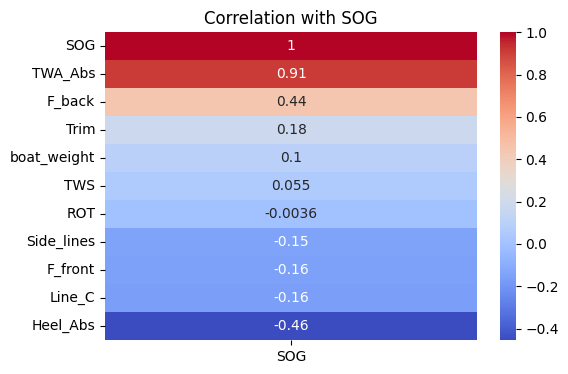


ANOVA:


,sum_sq,df,F,PR(>F)
TWA_Abs,13652.243641,1.0,16574.318485,0.000000e+00
boat_weight,3962.330162,1.0,4810.412396,0.000000e+00
TWS,711.471178,1.0,863.751791,4.227730e-178
F_front,367.952868,1.0,446.708115,7.162964e-96
Trim,125.912878,1.0,152.862796,1.028931e-34
Line_C,41.150189,1.0,49.957821,1.739243e-12
F_back,17.993309,1.0,21.844529,3.017731e-06
ROT,8.373362,1.0,10.165565,1.437840e-03
Heel_Abs,0.773173,1.0,0.938660,3.326597e-01
Side_lines,0.065879,1.0,0.079980,7.773341e-01



Polynomial fit:
R²: 0.890
Used samples: 6348

 Formula :
SOG ≈ 24.199 +
  0.014 * Heel_Abs +
  0.141 * Line_C +
  0.037 * ROT +
  0.004 * Side_lines +
  -0.154 * Trim +
  2.714 * TWA_Abs +
  0.345 * TWS +
  -0.000 * boat_weight +
  0.277 * F_front +
  0.068 * F_back


,feature,coefficient
5,TWA_Abs,2.713944e+00
6,TWS,3.447956e-01
8,F_front,2.767077e-01
4,Trim,-1.539614e-01
1,Line_C,1.407130e-01
9,F_back,6.810276e-02
2,ROT,3.650133e-02
0,Heel_Abs,1.400806e-02
3,Side_lines,3.908714e-03
7,boat_weight,-4.440892e-16


In [5]:
full_analysis(df_numeric)

## II Upwind:

### II.1. All upwind data

In [6]:
upwind_data = df[df['TWA'] >= 0]
df_numeric_upwind = upwind_data.select_dtypes(include=["float64", "int64"]).copy()
df_numeric_upwind.drop(columns=[c for c in drop_cols if c in df_numeric_upwind.columns], inplace=True)
df_numeric_upwind.dropna(subset=["SOG"], inplace=True)
print(f"Number of rows after filtering: {len(df_numeric_upwind)}")

Number of rows after filtering: 5895



Correlation with SOG:


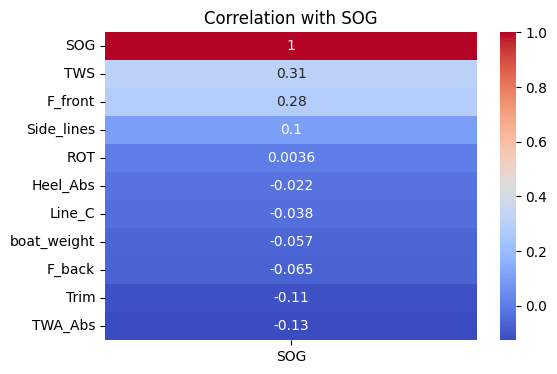


ANOVA:


,sum_sq,df,F,PR(>F)
boat_weight,3796.488994,1.0,7367.087316,0.000000e+00
TWS,323.997353,1.0,628.716900,4.758145e-129
F_front,170.848421,1.0,331.531380,3.005576e-71
TWA_Abs,40.942300,1.0,79.448538,7.359376e-19
Trim,24.903640,1.0,48.325517,4.193728e-12
Line_C,13.889600,1.0,26.952770,2.187855e-07
Side_lines,8.218301,1.0,15.947614,6.628210e-05
Heel_Abs,3.992126,1.0,7.746722,5.406122e-03
F_back,1.044205,1.0,2.026280,1.546761e-01
ROT,0.673322,1.0,1.306582,2.530824e-01



Polynomial fit:
R²: 0.315
Used samples: 4035

 Formula :
SOG ≈ 22.263 +
  -0.034 * Heel_Abs +
  0.065 * Line_C +
  -0.013 * ROT +
  -0.057 * Side_lines +
  -0.080 * Trim +
  -0.114 * TWA_Abs +
  0.298 * TWS +
  0.000 * boat_weight +
  0.267 * F_front +
  0.018 * F_back


,feature,coefficient
6,TWS,2.983109e-01
8,F_front,2.674951e-01
5,TWA_Abs,-1.140084e-01
4,Trim,-8.048520e-02
1,Line_C,6.512209e-02
3,Side_lines,-5.696340e-02
0,Heel_Abs,-3.423330e-02
9,F_back,1.840984e-02
2,ROT,-1.326450e-02
7,boat_weight,1.616762e-15


In [7]:
full_analysis(df_numeric_upwind)

### II.2. Upwind: Gian vs Karl
#### II.2.1. Upwind: Gian

In [8]:
gian_data_upwind = upwind_data[
    (upwind_data['boat_name'] == "Gian Stragiotti") |
    ((upwind_data['boat_name'] == "SenseBoard") & (upwind_data['opponent_name'] == "Karl Maeder"))
]
df_numeric_gian_upwind = gian_data_upwind.select_dtypes(include=["float64", "int64"]).copy()
df_numeric_gian_upwind.drop(columns=[c for c in drop_cols if c in df_numeric_gian_upwind.columns], inplace=True)
df_numeric_gian_upwind.dropna(subset=["SOG"], inplace=True)
print(f"Number of rows after filtering: {len(df_numeric_gian_upwind)}")

Number of rows after filtering: 4045


In [35]:
print(gian_data_upwind["boat_weight"].mean)

<bound method Series.mean of 11633    109.09
11637    109.09
11640    109.09
11645    109.09
11648    109.09
          ...  
40533    109.09
40535    109.09
40541    109.09
40544    109.09
40545    109.09
Name: boat_weight, Length: 4045, dtype: float64>



Correlation with SOG:


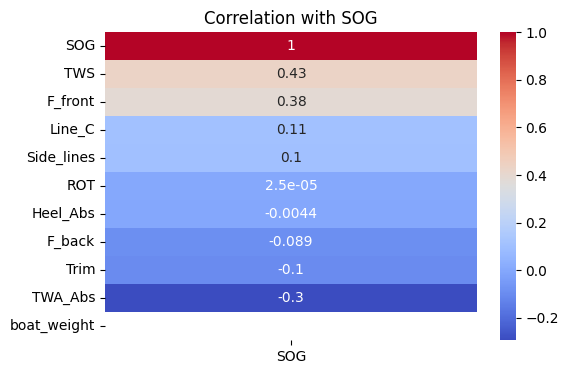


ANOVA:


,sum_sq,df,F,PR(>F)
boat_weight,3796.488994,1.0,7367.087316,0.000000e+00
TWS,323.997353,1.0,628.716900,4.758145e-129
F_front,170.848421,1.0,331.531380,3.005576e-71
TWA_Abs,40.942300,1.0,79.448538,7.359376e-19
Trim,24.903640,1.0,48.325517,4.193728e-12
Line_C,13.889600,1.0,26.952770,2.187855e-07
Side_lines,8.218301,1.0,15.947614,6.628210e-05
Heel_Abs,3.992126,1.0,7.746722,5.406122e-03
F_back,1.044205,1.0,2.026280,1.546761e-01
ROT,0.673322,1.0,1.306582,2.530824e-01



Polynomial fit:
R²: 0.315
Used samples: 4035

 Formula :
SOG ≈ 22.263 +
  -0.034 * Heel_Abs +
  0.065 * Line_C +
  -0.013 * ROT +
  -0.057 * Side_lines +
  -0.080 * Trim +
  -0.114 * TWA_Abs +
  0.298 * TWS +
  0.000 * boat_weight +
  0.267 * F_front +
  0.018 * F_back


,feature,coefficient
6,TWS,2.983109e-01
8,F_front,2.674951e-01
5,TWA_Abs,-1.140084e-01
4,Trim,-8.048520e-02
1,Line_C,6.512209e-02
3,Side_lines,-5.696340e-02
0,Heel_Abs,-3.423330e-02
9,F_back,1.840984e-02
2,ROT,-1.326450e-02
7,boat_weight,1.616762e-15


In [9]:
full_analysis(df_numeric_gian_upwind)

#### II.2.2. Upwind: Karl

In [10]:
karl_data_upwind = upwind_data[((upwind_data['boat_name'] == "SenseBoard") & (upwind_data['opponent_name'] == "Gian Stragiotti"))
]
df_numeric_karl_upwind = karl_data_upwind.select_dtypes(include=["float64", "int64"]).copy()
df_numeric_karl_upwind.drop(columns=[c for c in drop_cols if c in df_numeric_karl_upwind.columns], inplace=True)
df_numeric_karl_upwind.dropna(subset=["SOG"], inplace=True)
print(f"Number of rows after filtering: {len(df_numeric_karl_upwind)}")
print(df_numeric_karl_upwind.shape)
print(df_numeric_karl_upwind.columns)

Number of rows after filtering: 1850
(1850, 11)
Index(['Heel_Abs', 'Line_C', 'ROT', 'Side_lines', 'Trim', 'TWA_Abs', 'TWS',
       'SOG', 'boat_weight', 'F_front', 'F_back'],
      dtype='object')


In [36]:
print(karl_data_upwind["boat_weight"].mean)

<bound method Series.mean of 25553    102.89
25556    102.89
25557    102.89
25560    102.89
25562    102.89
          ...  
32146    102.89
32148    102.89
32149    102.89
32151    102.89
32153    102.89
Name: boat_weight, Length: 1850, dtype: float64>


In [11]:
df_numeric_karl_upwind.head(10)

,Heel_Abs,Line_C,ROT,Side_lines,Trim,TWA_Abs,TWS,SOG,boat_weight,F_front,F_back
25553,59.5,93.3,11.000,NaN,7.5,41.174,9.352,21.4,102.89,27567.598622,24661.188272
25556,57.4,88.1,-14.141,NaN,12.3,42.564,9.372,21.4,102.89,30282.257552,24532.446152
25557,59.8,98.4,1.020,NaN,8.7,42.454,9.391,21.3,102.89,30629.872010,26538.607253
25560,57.8,108.1,15.000,NaN,1.5,40.944,9.411,21.4,102.89,29534.445709,25671.679650
25562,53.0,111.4,-7.619,NaN,4.6,41.734,9.432,21.4,102.89,31969.060202,27080.840797
25563,54.8,111.3,-10.309,NaN,7.0,42.724,9.452,21.4,102.89,32674.719191,26459.098753
25565,54.6,110.7,11.224,NaN,7.0,41.614,9.471,21.3,102.89,34743.378192,26875.356725
25571,51.7,104.6,1.000,NaN,8.5,42.784,9.516,21.4,102.89,30655.266332,26253.937186
25573,60.9,110.8,21.782,NaN,10.3,40.574,9.526,21.3,102.89,35339.840155,26999.009743
25575,65.1,123.4,-12.000,NaN,7.7,41.764,9.536,21.2,102.89,35994.499228,27163.267808


Dropped column 'Side_lines' (all values were NaN).

Correlation with SOG:


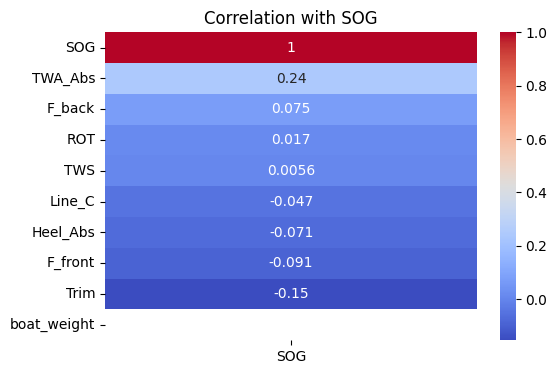


ANOVA:


,sum_sq,df,F,PR(>F)
boat_weight,1106.871555,1.0,2357.824086,0.000000e+00
TWA_Abs,64.815175,1.0,138.067313,8.600291e-31
F_back,20.724405,1.0,44.146497,4.000333e-11
Trim,19.836736,1.0,42.255610,1.028430e-10
F_front,13.052098,1.0,27.803182,1.501193e-07
Line_C,11.669872,1.0,24.858806,6.748056e-07
TWS,6.591465,1.0,14.040937,1.843859e-04
Heel_Abs,3.255098,1.0,6.933910,8.528436e-03
ROT,0.837738,1.0,1.784524,1.817599e-01
Residual,864.250453,1841.0,NaN,NaN



Polynomial fit:
R²: 0.123
Used samples: 1850

 Formula :
SOG ≈ 22.364 +
  -0.046 * Heel_Abs +
  -0.103 * Line_C +
  0.022 * ROT +
  -0.107 * Trim +
  0.192 * TWA_Abs +
  0.074 * TWS +
  -0.000 * boat_weight +
  -0.098 * F_front +
  0.130 * F_back


,feature,coefficient
4,TWA_Abs,1.918919e-01
8,F_back,1.296175e-01
3,Trim,-1.065003e-01
1,Line_C,-1.031950e-01
7,F_front,-9.760006e-02
5,TWS,7.404278e-02
0,Heel_Abs,-4.603214e-02
2,ROT,2.171276e-02
6,boat_weight,-3.191891e-16


In [12]:
full_analysis(df_numeric_karl_upwind)

#### II.2.3. Upwind: Karl vs Gian t_test

In [13]:
t_test(df_numeric_gian_upwind,df_numeric_karl_upwind)

T-statistic: -4.351, p-value: 0.000013771261761
The difference is statistically significant, keeping data split.


### II.3. Upwind: Master vs Slave
#### II.3.1. Master

In [14]:
master_data_upwind = upwind_data[upwind_data['boat_role'] == "master"]
df_numeric_master_upwind = master_data_upwind.select_dtypes(include=["float64", "int64"]).copy()
df_numeric_master_upwind.drop(columns=[c for c in drop_cols if c in df_numeric_master_upwind.columns], inplace=True)
df_numeric_master_upwind.dropna(subset=["SOG"], inplace=True)
print(f"Number of rows after filtering: {len(df_numeric_master_upwind)}")

Number of rows after filtering: 2867



Correlation with SOG:


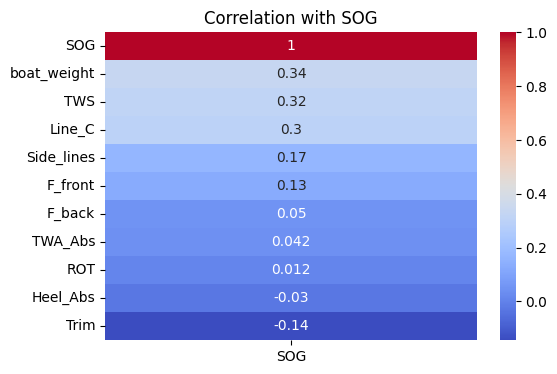


ANOVA:


,sum_sq,df,F,PR(>F)
boat_weight,1715.431933,1.0,4718.704952,0.000000e+00
TWS,138.554504,1.0,381.127232,2.292488e-77
F_front,134.666364,1.0,370.431974,1.984701e-75
TWA_Abs,45.253338,1.0,124.480107,5.012895e-28
Trim,11.035251,1.0,30.355093,4.098848e-08
Line_C,10.606735,1.0,29.176357,7.456883e-08
Heel_Abs,3.383133,1.0,9.306114,2.316150e-03
ROT,0.984495,1.0,2.708090,1.000093e-01
Side_lines,0.782011,1.0,2.151108,1.426360e-01
F_back,0.088594,1.0,0.243699,6.216057e-01



Polynomial fit:
R²: 0.359
Used samples: 1871

 Formula :
SOG ≈ 22.733 +
  -0.047 * Heel_Abs +
  0.085 * Line_C +
  -0.024 * ROT +
  -0.027 * Side_lines +
  -0.079 * Trim +
  -0.199 * TWA_Abs +
  0.309 * TWS +
  0.000 * boat_weight +
  0.331 * F_front +
  -0.009 * F_back


,feature,coefficient
8,F_front,3.311597e-01
6,TWS,3.089292e-01
5,TWA_Abs,-1.990465e-01
1,Line_C,8.498961e-02
4,Trim,-7.919289e-02
0,Heel_Abs,-4.689885e-02
3,Side_lines,-2.655224e-02
2,ROT,-2.383201e-02
9,F_back,-8.756167e-03
7,boat_weight,3.330669e-16


In [15]:
full_analysis(df_numeric_master_upwind)

#### II.3.2 Slave

In [16]:
slave_data_upwind = upwind_data[upwind_data['boat_role'] == "slave"]
df_numeric_slave_upwind = slave_data_upwind.select_dtypes(include=["float64", "int64"]).copy()
df_numeric_slave_upwind.drop(columns=[c for c in drop_cols if c in df_numeric_slave_upwind.columns], inplace=True)
df_numeric_slave_upwind.dropna(subset=["SOG"], inplace=True)
print(f"Number of rows after filtering: {len(df_numeric_slave_upwind)}")

Number of rows after filtering: 3028



Correlation with SOG:


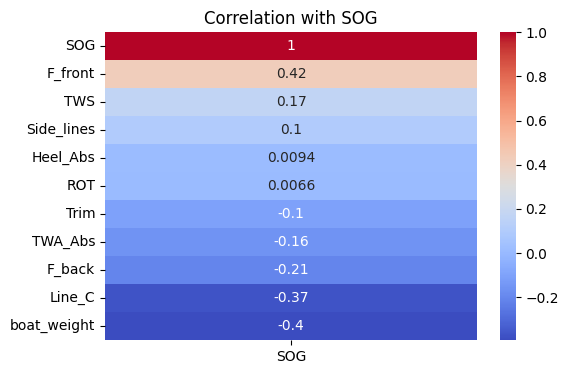


ANOVA:


,sum_sq,df,F,PR(>F)
boat_weight,2168.313320,1.0,5567.732017,0.000000e+00
F_front,69.886220,1.0,179.451808,2.294978e-39
TWA_Abs,69.368709,1.0,178.122958,4.252968e-39
Trim,11.469002,1.0,29.449771,6.383047e-08
Line_C,6.685566,1.0,17.167002,3.555600e-05
Side_lines,6.135723,1.0,15.755131,7.445409e-05
Heel_Abs,3.606872,1.0,9.261620,2.368339e-03
ROT,1.279353,1.0,3.285084,7.005120e-02
TWS,0.704324,1.0,1.808543,1.788247e-01
F_back,0.011746,1.0,0.030161,8.621428e-01



Polynomial fit:
R²: 0.300
Used samples: 2164

 Formula :
SOG ≈ 21.855 +
  -0.044 * Heel_Abs +
  0.062 * Line_C +
  -0.025 * ROT +
  -0.067 * Side_lines +
  -0.075 * Trim +
  -0.215 * TWA_Abs +
  0.024 * TWS +
  -0.000 * boat_weight +
  0.263 * F_front +
  0.003 * F_back


,feature,coefficient
8,F_front,2.626987e-01
5,TWA_Abs,-2.148419e-01
4,Trim,-7.477915e-02
3,Side_lines,-6.695012e-02
1,Line_C,6.171636e-02
0,Heel_Abs,-4.401527e-02
2,ROT,-2.493906e-02
6,TWS,2.366783e-02
9,F_back,2.628575e-03
7,boat_weight,-1.387779e-17


In [17]:
full_analysis(df_numeric_slave_upwind)

#### III.3.3. Upwind: Master vs Slave t_test

In [18]:
t_test(df_numeric_master_upwind,df_numeric_slave_upwind)

T-statistic: 23.713, p-value: 0.000000000000000
The difference is statistically significant, keeping data split.


## III Downwind
### III.1. All downwind data

In [19]:
downwind_data = df[df['TWA'] < 0]
df_numeric_downwind = downwind_data.select_dtypes(include=["float64", "int64"]).copy()
df_numeric_downwind.drop(columns=[c for c in drop_cols if c in df_numeric_downwind.columns], inplace=True)
df_numeric_downwind.dropna(subset=["SOG"], inplace=True)
print(f"Number of rows after filtering: {len(df_numeric_downwind)}")

Number of rows after filtering: 3252



Correlation with SOG:


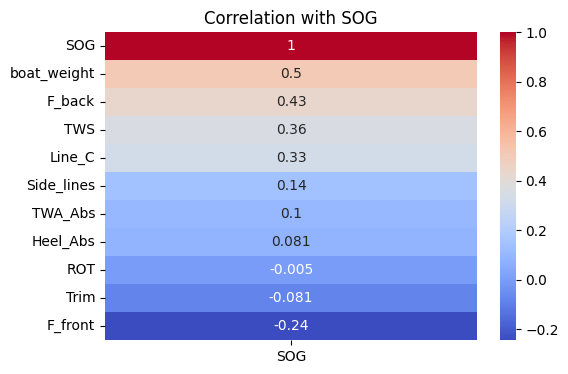


ANOVA:


,sum_sq,df,F,PR(>F)
boat_weight,572.755327,1.0,631.030397,2.816700e-123
TWS,274.223409,1.0,302.124308,1.101922e-63
F_back,153.516870,1.0,169.136465,2.286593e-37
TWA_Abs,45.296593,1.0,49.905301,2.128750e-12
Trim,41.907108,1.0,46.170953,1.375193e-11
Line_C,35.220756,1.0,38.804296,5.552596e-10
Heel_Abs,14.895797,1.0,16.411372,5.266656e-05
F_front,4.874909,1.0,5.370907,2.056259e-02
ROT,1.441461,1.0,1.588123,2.077222e-01
Side_lines,0.074390,1.0,0.081959,7.746863e-01



Polynomial fit:
R²: 0.243
Used samples: 2313

 Formula :
SOG ≈ 27.578 +
  0.106 * Heel_Abs +
  0.177 * Line_C +
  -0.027 * ROT +
  -0.007 * Side_lines +
  -0.186 * Trim +
  0.154 * TWA_Abs +
  0.364 * TWS +
  0.000 * boat_weight +
  0.050 * F_front +
  0.301 * F_back


,feature,coefficient
6,TWS,3.635678e-01
9,F_back,3.006649e-01
4,Trim,-1.856711e-01
1,Line_C,1.774845e-01
5,TWA_Abs,1.543814e-01
0,Heel_Abs,1.056453e-01
8,F_front,5.003873e-02
2,ROT,-2.673272e-02
3,Side_lines,-6.842591e-03
7,boat_weight,5.551115e-17


In [20]:

full_analysis(df_numeric_downwind)

### III.2. Downwind: Gian vs Karl
#### III.2.1. Downwind: Gian

In [21]:
gian_data_downwind = downwind_data[
    (downwind_data['boat_name'] == "Gian Stragiotti") |
    ((downwind_data['boat_name'] == "SenseBoard") & (downwind_data['opponent_name'] == "Karl Maeder"))
]
df_numeric_gian_downwind = gian_data_downwind.select_dtypes(include=["float64", "int64"]).copy()
df_numeric_gian_downwind.drop(columns=[c for c in drop_cols if c in df_numeric_gian_downwind.columns], inplace=True)
df_numeric_gian_downwind.dropna(subset=["SOG"], inplace=True)
print(f"Number of rows after filtering: {len(df_numeric_gian_downwind)}")

Number of rows after filtering: 2327



Correlation with SOG:


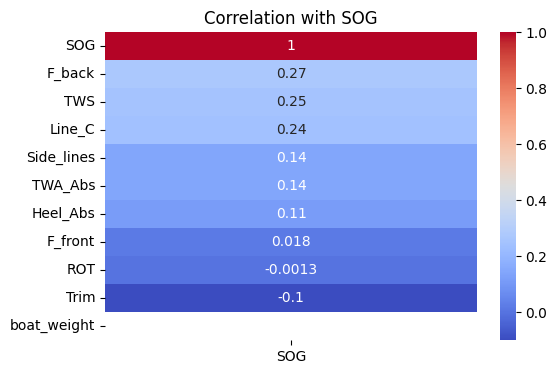


ANOVA:


,sum_sq,df,F,PR(>F)
boat_weight,572.755327,1.0,631.030397,2.816700e-123
TWS,274.223409,1.0,302.124308,1.101922e-63
F_back,153.516870,1.0,169.136465,2.286593e-37
TWA_Abs,45.296593,1.0,49.905301,2.128750e-12
Trim,41.907108,1.0,46.170953,1.375193e-11
Line_C,35.220756,1.0,38.804296,5.552596e-10
Heel_Abs,14.895797,1.0,16.411372,5.266656e-05
F_front,4.874909,1.0,5.370907,2.056259e-02
ROT,1.441461,1.0,1.588123,2.077222e-01
Side_lines,0.074390,1.0,0.081959,7.746863e-01



Polynomial fit:
R²: 0.243
Used samples: 2313

 Formula :
SOG ≈ 27.578 +
  0.106 * Heel_Abs +
  0.177 * Line_C +
  -0.027 * ROT +
  -0.007 * Side_lines +
  -0.186 * Trim +
  0.154 * TWA_Abs +
  0.364 * TWS +
  0.000 * boat_weight +
  0.050 * F_front +
  0.301 * F_back


,feature,coefficient
6,TWS,3.635678e-01
9,F_back,3.006649e-01
4,Trim,-1.856711e-01
1,Line_C,1.774845e-01
5,TWA_Abs,1.543814e-01
0,Heel_Abs,1.056453e-01
8,F_front,5.003873e-02
2,ROT,-2.673272e-02
3,Side_lines,-6.842591e-03
7,boat_weight,5.551115e-17


In [22]:

full_analysis(df_numeric_gian_downwind)

#### III.2.2. Downwind: Karl

In [23]:
karl_data_downwind = downwind_data[
    (downwind_data['boat_name'] == "Karl Maeder") |
    ((downwind_data['boat_name'] == "SenseBoard") & (downwind_data['opponent_name'] == "Gian Stragiotti"))
]
df_numeric_karl_downwind = karl_data_downwind.select_dtypes(include=["float64", "int64"]).copy()
df_numeric_karl_downwind.drop(columns=[c for c in drop_cols if c in df_numeric_karl_downwind.columns], inplace=True)
df_numeric_karl_downwind.dropna(subset=["SOG"], inplace=True)
print(f"Number of rows after filtering: {len(df_numeric_karl_downwind)}")

Number of rows after filtering: 925


Dropped column 'Side_lines' (all values were NaN).

Correlation with SOG:


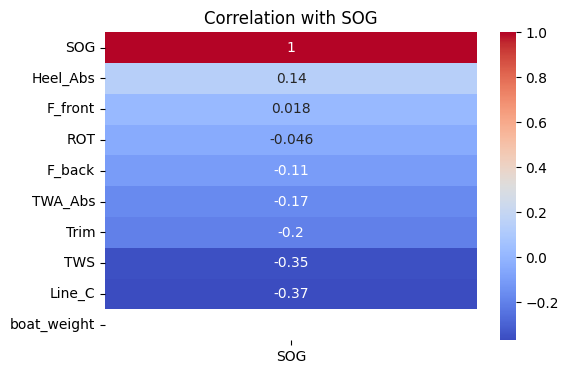


ANOVA:


,sum_sq,df,F,PR(>F)
boat_weight,134.672490,1.0,234.409729,2.801748e-47
Line_C,82.562650,1.0,143.707809,7.359884e-31
Trim,72.909277,1.0,126.905234,1.171318e-27
TWA_Abs,63.124393,1.0,109.873753,2.347450e-24
Heel_Abs,59.200786,1.0,103.044358,5.143494e-23
F_front,18.992257,1.0,33.057753,1.218654e-08
F_back,18.816061,1.0,32.751067,1.419092e-08
ROT,9.148650,1.0,15.924059,7.120832e-05
TWS,0.521305,1.0,0.907379,3.410625e-01
Residual,525.683506,915.0,NaN,NaN



Polynomial fit:
R²: 0.331
Used samples: 924

 Formula :
SOG ≈ 26.220 +
  0.312 * Heel_Abs +
  -0.601 * Line_C +
  -0.109 * ROT +
  -0.343 * Trim +
  0.439 * TWA_Abs +
  -0.035 * TWS +
  0.000 * boat_weight +
  0.205 * F_front +
  -0.214 * F_back


,feature,coefficient
1,Line_C,-0.601447
4,TWA_Abs,0.438604
3,Trim,-0.342645
0,Heel_Abs,0.312427
8,F_back,-0.214021
7,F_front,0.204543
2,ROT,-0.109280
5,TWS,-0.034704
6,boat_weight,0.000000


In [24]:
full_analysis(df_numeric_karl_downwind)

#### III.2.3. Downwind: Karl vs Gian t_test

In [25]:
t_test(df_numeric_karl_downwind,df_numeric_gian_downwind)

T-statistic: -33.288, p-value: 0.000000000000000
The difference is statistically significant, keeping data split.


### III.3. Downwind: Master vs Slave
#### III.3.1 Downwind Master

In [26]:
master_data_downwind = downwind_data[downwind_data['boat_role'] == "master"]
df_numeric_master_downwind = master_data_downwind.select_dtypes(include=["float64", "int64"]).copy()
df_numeric_master_downwind.drop(columns=[c for c in drop_cols if c in df_numeric_master_downwind.columns], inplace=True)
df_numeric_master_downwind.dropna(subset=["SOG"], inplace=True)
print(f"Number of rows after filtering: {len(df_numeric_master_downwind)}")

Number of rows after filtering: 1673



Correlation with SOG:


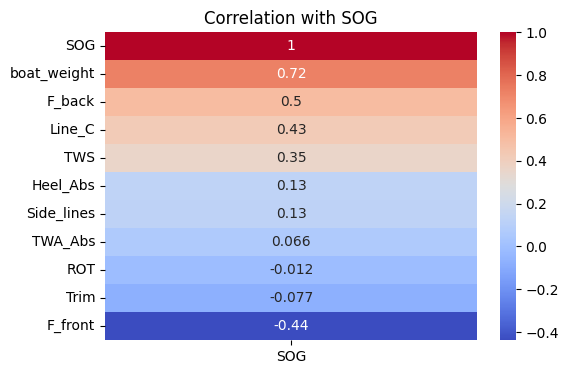


ANOVA:


,sum_sq,df,F,PR(>F)
boat_weight,475.532479,1.0,747.709706,3.079565e-124
Line_C,35.397225,1.0,55.657289,1.828655e-13
TWS,14.763508,1.0,23.213595,1.667025e-06
F_back,14.228148,1.0,22.371814,2.558829e-06
F_front,11.900236,1.0,18.711491,1.668352e-05
Heel_Abs,11.748899,1.0,18.473536,1.885966e-05
Trim,10.310448,1.0,16.211767,6.079127e-05
TWA_Abs,2.825412,1.0,4.442574,3.529428e-02
Side_lines,0.417646,1.0,0.656690,4.179178e-01
ROT,0.104722,1.0,0.164660,6.849857e-01



Polynomial fit:
R²: 0.199
Used samples: 1041

 Formula :
SOG ≈ 27.766 +
  0.141 * Heel_Abs +
  0.270 * Line_C +
  -0.011 * ROT +
  -0.024 * Side_lines +
  -0.137 * Trim +
  0.061 * TWA_Abs +
  0.137 * TWS +
  0.000 * boat_weight +
  0.120 * F_front +
  0.149 * F_back


,feature,coefficient
1,Line_C,0.270093
9,F_back,0.149055
0,Heel_Abs,0.140808
6,TWS,0.137100
4,Trim,-0.136734
8,F_front,0.119865
5,TWA_Abs,0.061201
3,Side_lines,-0.023867
2,ROT,-0.010789
7,boat_weight,0.000000


In [27]:
full_analysis(df_numeric_master_downwind)

#### III.3.2 Downwind Slave

In [28]:
slave_data_downwind = downwind_data[downwind_data['boat_role'] == "slave"]
df_numeric_slave_downwind = slave_data_downwind.select_dtypes(include=["float64", "int64"]).copy()
df_numeric_slave_downwind.drop(columns=[c for c in drop_cols if c in df_numeric_slave_downwind.columns], inplace=True)
df_numeric_slave_downwind.dropna(subset=["SOG"], inplace=True)
print(f"Number of rows after filtering: {len(df_numeric_slave_downwind)}")

Number of rows after filtering: 1579



Correlation with SOG:


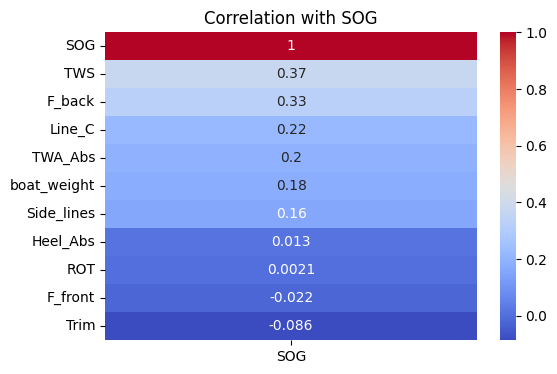


ANOVA:


,sum_sq,df,F,PR(>F)
TWS,213.269940,1.0,210.003007,3.892156e-44
F_back,134.309265,1.0,132.251875,3.537588e-29
boat_weight,105.120338,1.0,103.510073,2.017222e-23
TWA_Abs,74.474377,1.0,73.333556,3.140916e-17
Trim,39.311792,1.0,38.709602,6.677306e-10
F_front,13.542607,1.0,13.335157,2.711376e-04
Line_C,8.989642,1.0,8.851936,2.983480e-03
Heel_Abs,2.721339,1.0,2.679652,1.018872e-01
ROT,2.524669,1.0,2.485995,1.151143e-01
Side_lines,0.844044,1.0,0.831115,3.621245e-01



Polynomial fit:
R²: 0.317
Used samples: 1272

 Formula :
SOG ≈ 27.424 +
  0.061 * Heel_Abs +
  0.119 * Line_C +
  -0.048 * ROT +
  -0.032 * Side_lines +
  -0.253 * Trim +
  0.289 * TWA_Abs +
  0.435 * TWS +
  -0.000 * boat_weight +
  0.127 * F_front +
  0.381 * F_back


,feature,coefficient
6,TWS,4.348628e-01
9,F_back,3.806385e-01
5,TWA_Abs,2.893166e-01
4,Trim,-2.534349e-01
8,F_front,1.270119e-01
1,Line_C,1.194666e-01
0,Heel_Abs,6.086844e-02
2,ROT,-4.777471e-02
3,Side_lines,-3.217578e-02
7,boat_weight,-1.804112e-16


In [29]:
full_analysis(df_numeric_slave_downwind)

#### III.3.3. Downwind: Master vs Slave t_test

In [30]:
t_test(df_numeric_master_downwind,df_numeric_slave_downwind)

T-statistic: -6.001, p-value: 0.000000002171240
The difference is statistically significant, keeping data split.
